<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Omid Jafaei
### Student ID: 401204268

# Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Data Visualization

In [ ]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

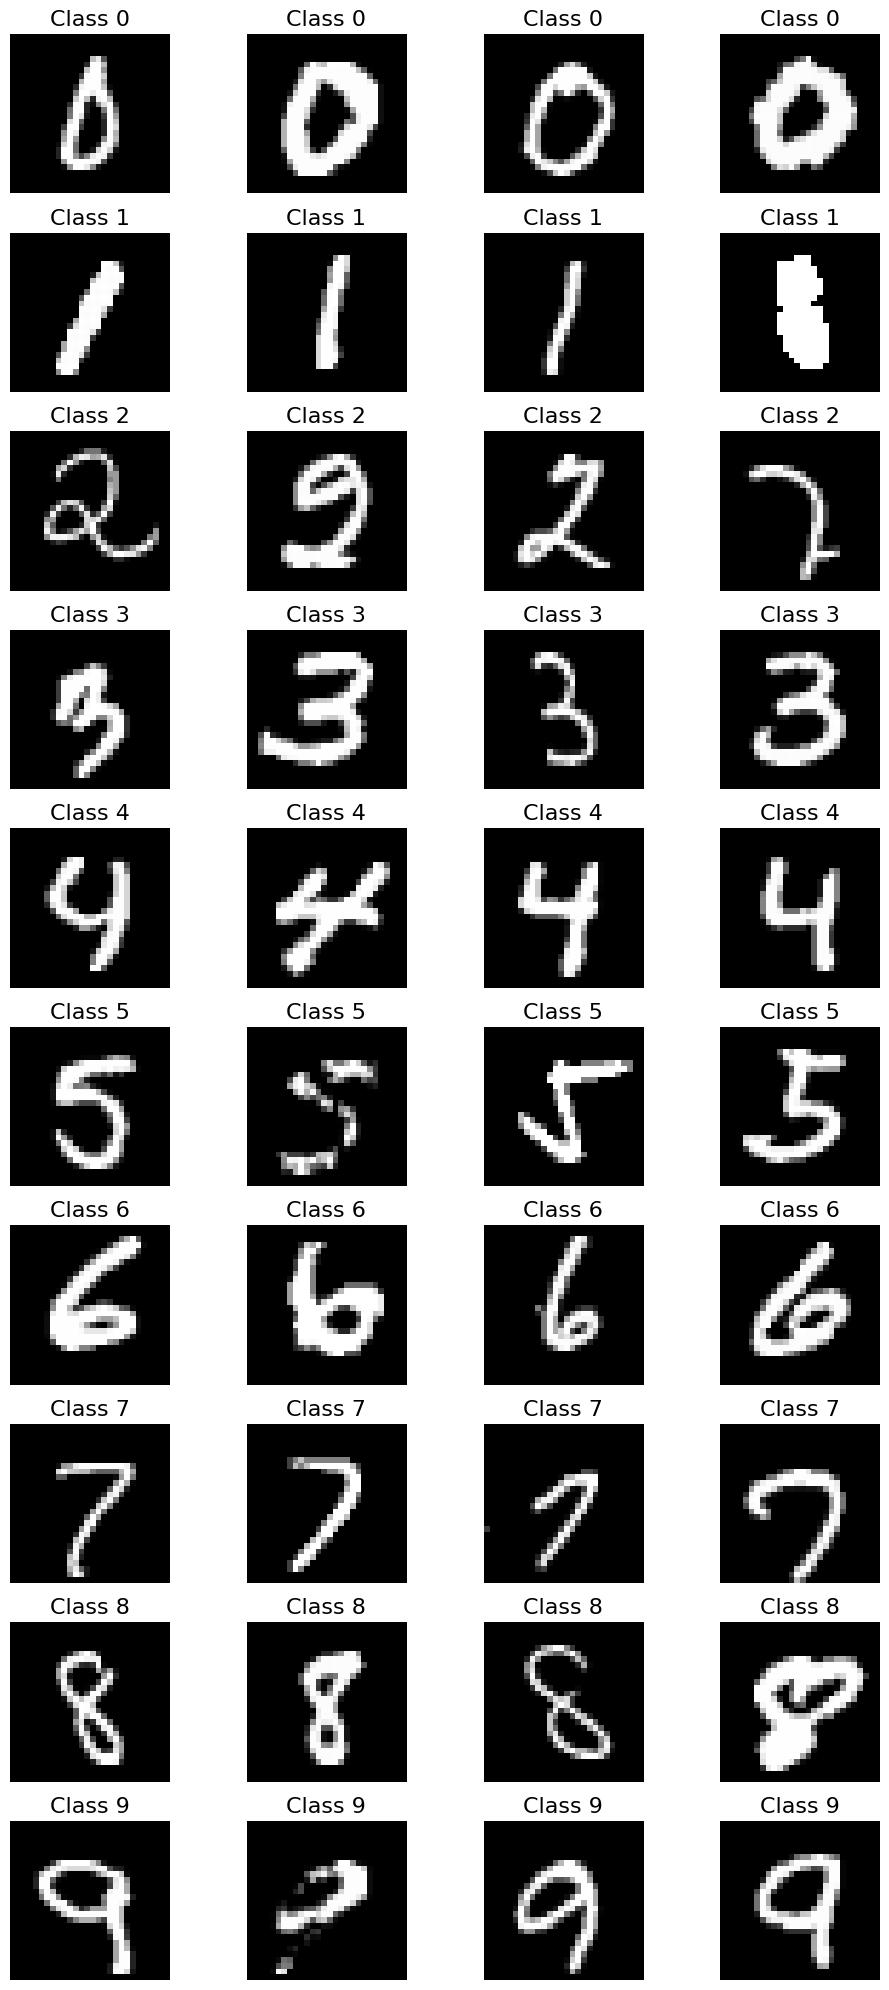

In [ ]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [ ]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
                                     nn.Linear(in_features = input_dim, out_features = hidden_dim[0], bias=True),
                                     nn.ReLU(),
                                     nn.Linear(in_features = hidden_dim[0], out_features = hidden_dim[1], bias=True),
                                     nn.ReLU(),
                                     nn.Linear(in_features = hidden_dim[1], out_features = hidden_dim[2], bias=True),
                                     nn.ReLU()
        )
        self.fc_mu = nn.Linear(in_features = hidden_dim[2], out_features = latent_dim)
        self.fc_logvar = nn.Linear(in_features = hidden_dim[2], out_features = latent_dim)
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
                                     nn.Linear(in_features = latent_dim, out_features = hidden_dim[2], bias=True),
                                     nn.ReLU(),
                                     nn.Linear(in_features = hidden_dim[2], out_features = hidden_dim[1], bias=True),
                                     nn.ReLU(),
                                     nn.Linear(in_features = hidden_dim[1], out_features = hidden_dim[0], bias=True),
                                     nn.ReLU(),
                                     nn.Linear(in_features = hidden_dim[0], out_features = input_dim, bias=True),
                                     nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        eps = torch.randn(mu.size(0), mu.size(1)).to(mu.get_device())
        z = mu + eps * torch.exp(logvar/2)
        return z

    def forward(self, x):
        # TODO: Implement the forward pass
        x = self.encoder(x)
        z_mu = self.fc_mu(x)
        z_logvar = self.fc_logvar(x)
        reparam = self.reparameterize(z_mu, z_logvar)
        decoded = self.decoder(reparam)
        return z_mu, z_logvar, reparam, decoded

In [ ]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = nn.MSELoss()
    reconstruction_loss = reconstruction_loss(recon, data)

    # TODO: Implement the KL divergence loss
    kl_divergence = 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1 - logvar, dim = -1)
    kl_divergence = kl_divergence.mean()

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    return reconstruction_loss + 1e-4*kl_divergence

In [ ]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = []
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            data = torch.flatten(data, start_dim=1)
            data = data.to(device)
            model = model.to(device)
            z_mu, z_logvar, reparam, decoded = model(data)
            # TODO: Flatten the data and recon tensors
            recon = torch.flatten(decoded, start_dim=1)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, z_mu, z_logvar)

            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())

        avg_loss = float(sum(total_loss)/len(total_loss))
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                model = model.cpu()
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model  # TODO: Save the model

    # TODO: Save the best model to a file
    #torch.save(best_model, 'best_vae_mlp_model.pth')
    torch.save({
            'best_vae_mlp_model_state_dict': best_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/10], Loss: 0.05509196606669218
Sample Images:


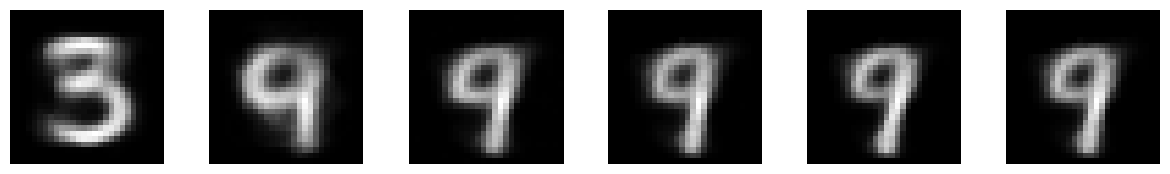


##################################################
VAE-MLP Epoch [2/10], Loss: 0.0439338825230024
Sample Images:


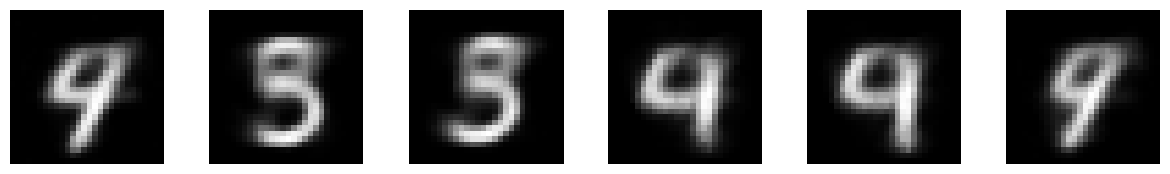


##################################################
VAE-MLP Epoch [3/10], Loss: 0.0417874961305084
Sample Images:


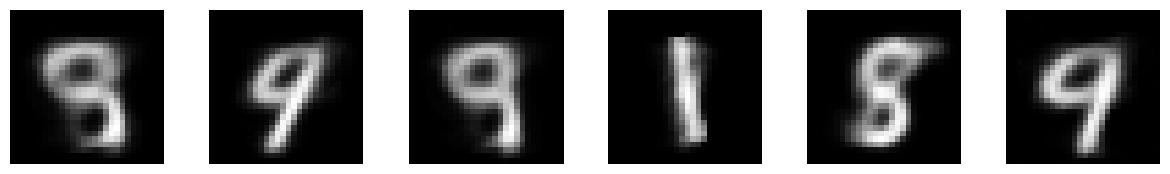


##################################################
VAE-MLP Epoch [4/10], Loss: 0.040732593583399805
Sample Images:


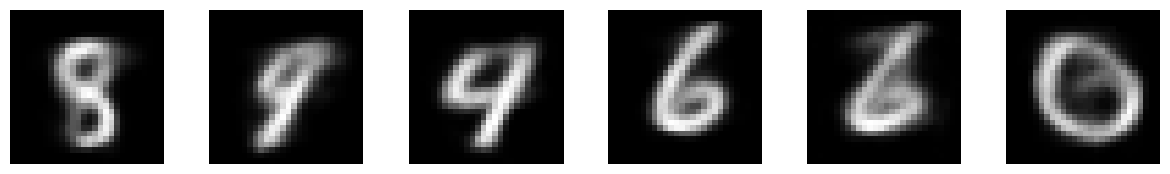


##################################################
VAE-MLP Epoch [5/10], Loss: 0.03959375623462678
Sample Images:


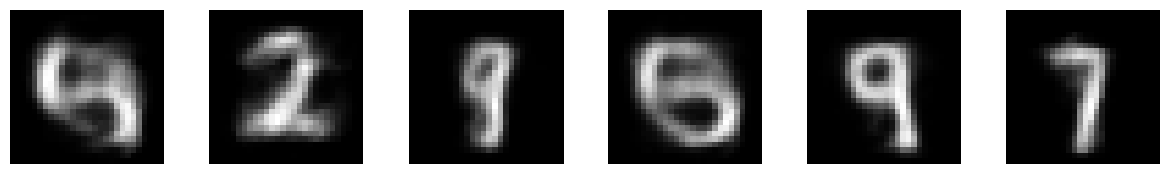


##################################################
VAE-MLP Epoch [6/10], Loss: 0.03884537050575971
Sample Images:


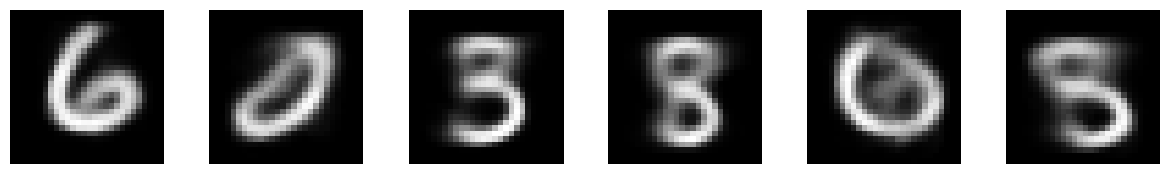


##################################################
VAE-MLP Epoch [7/10], Loss: 0.03841034144457024
Sample Images:


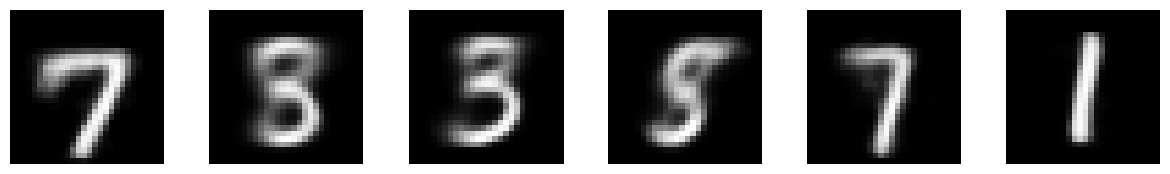


##################################################
VAE-MLP Epoch [8/10], Loss: 0.03797123330964971
Sample Images:


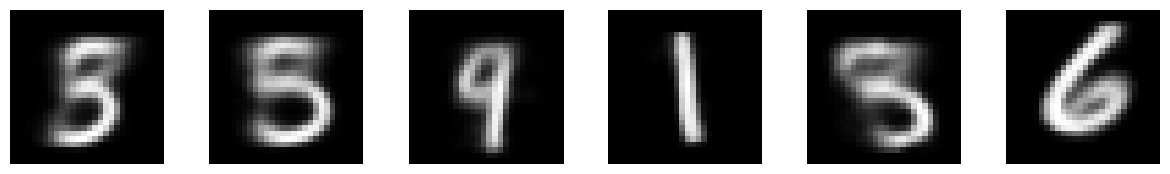


##################################################
VAE-MLP Epoch [9/10], Loss: 0.03819076775678439
Sample Images:


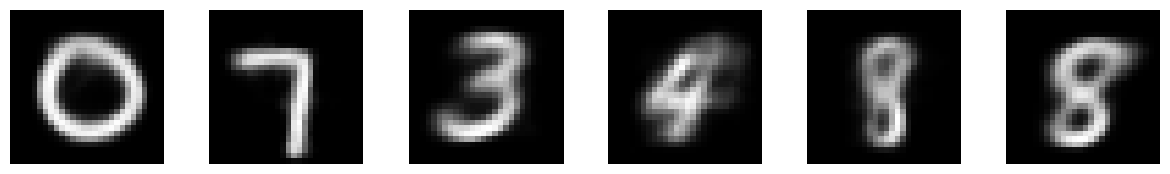


##################################################
VAE-MLP Epoch [10/10], Loss: 0.03763087050143336
Sample Images:


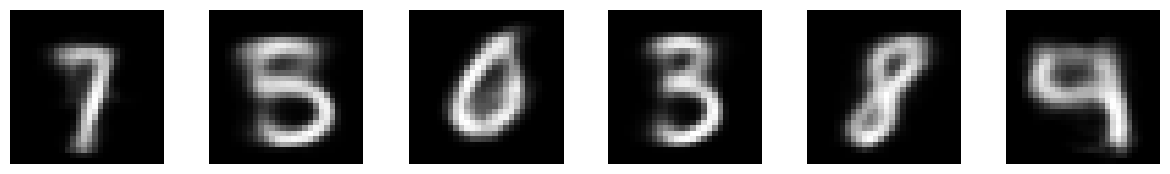

Best model saved as 'best_vae_mlp_model.pth'


In [ ]:
# Train VAE-MLP
vae_mlp = VAE_MLP(784, [392,196,98], 2)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [ ]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
                                     nn.Linear(in_features = input_dim + num_classes, out_features = hidden_dim[0], bias=True),
                                     nn.ReLU(),
                                     nn.Linear(in_features = hidden_dim[0], out_features = hidden_dim[1], bias=True),
                                     nn.ReLU(),
                                     nn.Linear(in_features = hidden_dim[1], out_features = hidden_dim[2], bias=True),
                                     nn.ReLU()
        )
        self.fc_mu = nn.Linear(in_features = hidden_dim[2], out_features = latent_dim)
        self.fc_logvar = nn.Linear(in_features = hidden_dim[2], out_features = latent_dim)
        self.fc_class = nn.Linear(in_features = hidden_dim[2], out_features = num_classes)

        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
                                     nn.Linear(in_features = latent_dim + num_classes, out_features = hidden_dim[2], bias=True),
                                     nn.ReLU(),
                                     nn.Linear(in_features = hidden_dim[2], out_features = hidden_dim[1], bias=True),
                                     nn.ReLU(),
                                     nn.Linear(in_features = hidden_dim[1], out_features = hidden_dim[0], bias=True),
                                     nn.ReLU(),
                                     nn.Linear(in_features = hidden_dim[0], out_features = input_dim, bias=True),
                                     nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        eps = torch.randn(mu.size(0), mu.size(1)).to(mu.get_device())
        z = mu + eps * torch.exp(logvar/2)
        return z

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat([x, y], dim = 1)

        # TODO: Implement the forward pass
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)
        decoder_input = torch.cat([z, y], dim = 1)
        reconstructed = self.decoder(decoder_input)

        return reconstructed, mu, logvar, class_logits, z


In [ ]:
def one_hot(labels, num_classes):
    targets = torch.zeros(labels.size(0), num_classes)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets

In [ ]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = torch.flatten(data, start_dim=1)

    # TODO: Implement the reconstruction loss
    reconstruction_loss = nn.MSELoss()
    reconstruction_loss = reconstruction_loss(recon, data)

    # TODO: Implement the KL divergence loss
    kl_divergence = 0.5 * torch.sum(torch.exp(logvar) + mu**2 - 1 - logvar, dim = -1)
    kl_divergence = kl_divergence.mean()

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = nn.CrossEntropyLoss()
    ce_loss = ce_loss(class_logits, labels)

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return reconstruction_loss + 1e-4*kl_divergence + 1e-4*ce_loss


In [ ]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = []
        for batch_idx, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = one_hot(labels, 10)
            data = data.to(device)
            labels_one_hot = labels_one_hot.to(device)
            model = model.to(device)
            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits, z = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels_one_hot)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())


        avg_loss = float(sum(total_loss)/len(total_loss))
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                model = model.cpu()
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model

    # TODO: Save the best model to a file
    #torch.save(best_model.state_dict(), 'best_cvae_mlp_model.pth')
    torch.save({
        'best_vae_mlp_model_state_dict': best_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 0.04714354941808085
Sample Images:


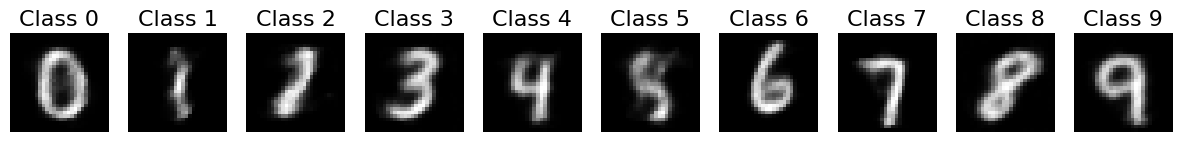


##################################################
CVAE-MLP Epoch [2/10], Loss: 0.0364871057910102
Sample Images:


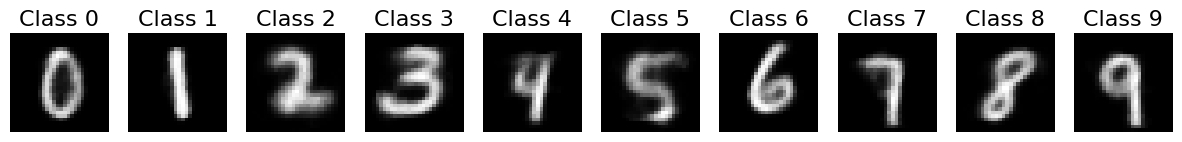


##################################################
CVAE-MLP Epoch [3/10], Loss: 0.03487695766283251
Sample Images:


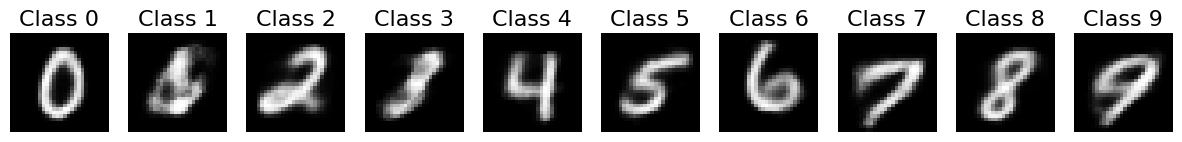


##################################################
CVAE-MLP Epoch [4/10], Loss: 0.034066087496814446
Sample Images:


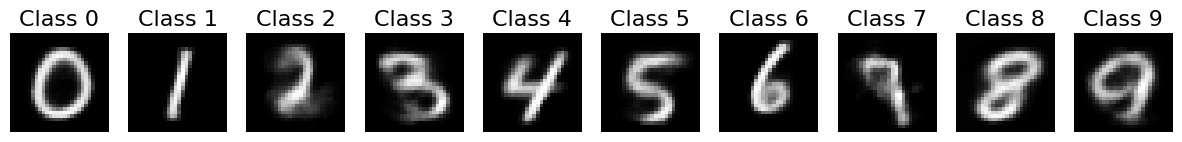


##################################################
CVAE-MLP Epoch [5/10], Loss: 0.03358974157850435
Sample Images:


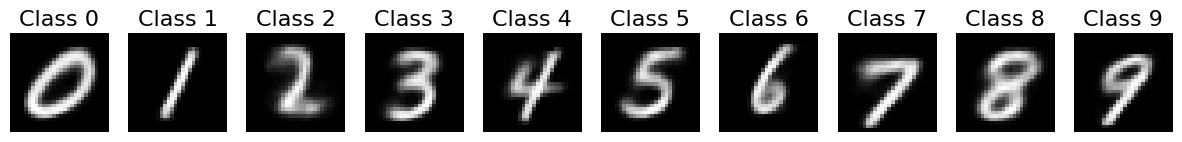


##################################################
CVAE-MLP Epoch [6/10], Loss: 0.03322197703211737
Sample Images:


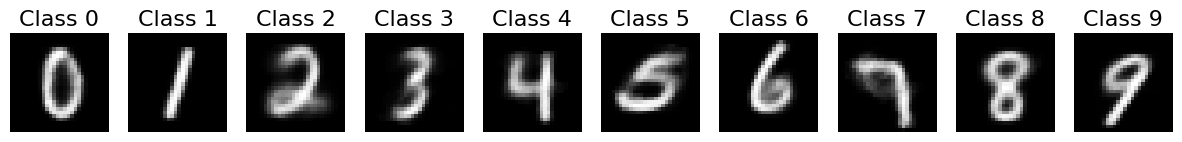


##################################################
CVAE-MLP Epoch [7/10], Loss: 0.03294074450776394
Sample Images:


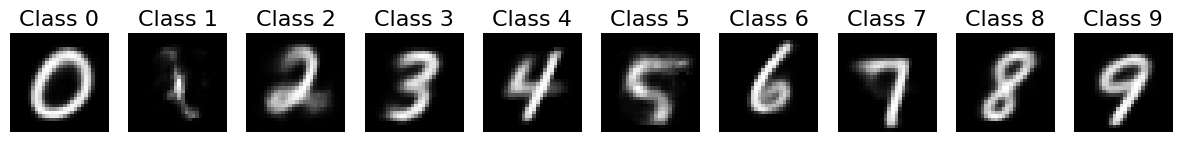


##################################################
CVAE-MLP Epoch [8/10], Loss: 0.0327097377034901
Sample Images:


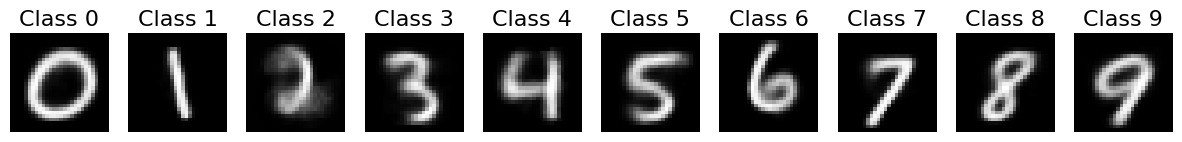


##################################################
CVAE-MLP Epoch [9/10], Loss: 0.032524743637661814
Sample Images:


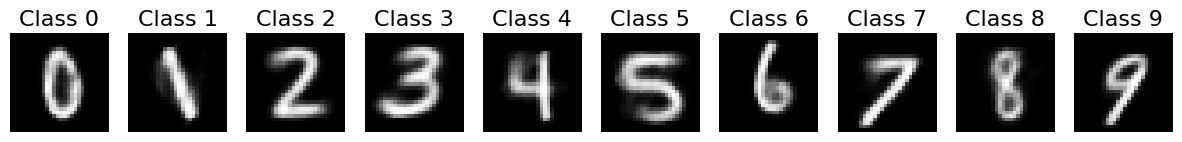


##################################################
CVAE-MLP Epoch [10/10], Loss: 0.03230863506955379
Sample Images:


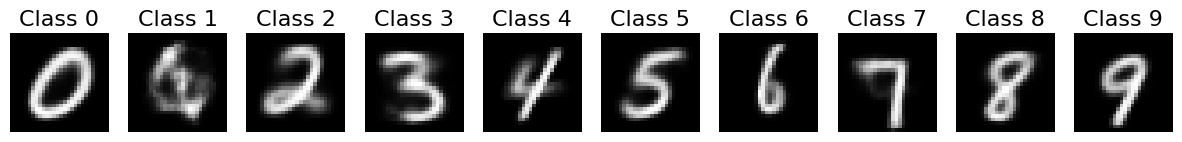

Best model saved as 'best_cvae_mlp_model.pth'


In [ ]:
cvae_mlp = CVAE_MLP(784, [392,196,98], 2, 10)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


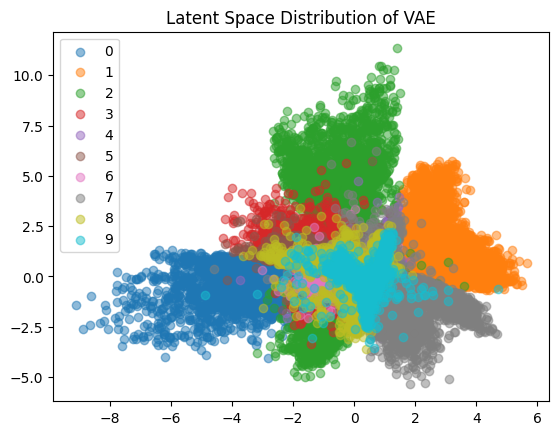

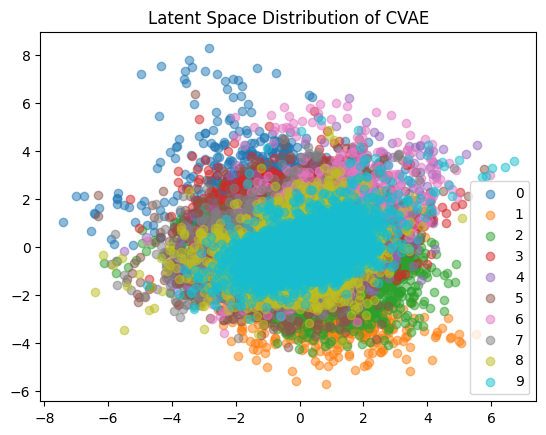

In [ ]:
import matplotlib.colors as mcolors
def plot_latent_space_with_labels(num_classes, data_loader, model, device, model_type):
    d = {i:[] for i in range(num_classes)}
    plt.figure()
    with torch.no_grad():
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            model = model.to(device)
            if model_type == 'VAE':
               targets = targets.to(device)
               features = torch.flatten(features, start_dim = 1)
               z_mu, z_logvar, embedding, decoded = model(features)
            elif model_type == 'CVAE':
               labels_one_hot = one_hot(targets, 10)
               labels_one_hot = labels_one_hot.to(device)
               z_mu, z_logvar, cl, decoded, embedding = model(features, labels_one_hot)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])

        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            color=colors[i][1],
            label=f'{i}',
            alpha=0.5)

    plt.legend()
    if model_type == 'VAE':
       plt.title('Latent Space Distribution of VAE')
    elif model_type == 'CVAE':
       plt.title('Latent Space Distribution of CVAE')


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plot_latent_space_with_labels(10, train_loader, vae_mlp, device, 'VAE')
plot_latent_space_with_labels(10, train_loader, cvae_mlp, device, 'CVAE')

In a conditional VAE, the approximate posterior is already conditioned on the class -- q(z|X,c)
, so there is no need for the latent space to separate the class of each input. Since the decoder is also conditioned on the class, it knows how to produce different classes.
The latent space of CVAE is probably modeling other types of "style" -- thickness, tilt, size, etc of the digits.